## Access ARGO Core data in Parquet

A jupyter notebook to show how to access and plot ARGO Core data available as a [Parquet](https://parquet.apache.org) dataset on S3

In [1]:
dataset_name = "argo_core_yearly_geom"

## Install/Update packages and Load common functions

In [ ]:
# only run once, then restart session and comment the next 3 lines
!pip install s3fs -U
!pip install pyarrow==16.0.0 -U
!pip install zarr xarray[complete]
!pip install pandas==2.2.2 -U

In [ ]:
import requests
import os
if not os.path.exists('parquet_queries.py'):
  print('Downloading parquet_queries.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/parquet_queries.py'
  response = requests.get(url)
  with open('parquet_queries.py', 'w') as f:
      f.write(response.text)

In [2]:
from parquet_queries import create_time_filter, create_bbox_filter, query_unique_value, plot_spatial_extent, get_spatial_extent, get_temporal_extent, get_schema_metadata
import pyarrow.parquet as pq
import pyarrow.dataset as pds
import pyarrow as pa
import os
import pandas as pd
import pyarrow.compute as pc

## Location of the parquet dataset

In [3]:
BUCKET_OPTIMISED_DEFAULT="imos-data-lab-optimised"
dname = f"s3://{BUCKET_OPTIMISED_DEFAULT}/parquet/loz_test/{dataset_name}/"
parquet_ds = pq.ParquetDataset(dname,partitioning='hive')

# Understanding the Dataset

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [4]:
dataset = pds.dataset(dname, format="parquet", partitioning="hive")

partition_keys = dataset.partitioning.schema
print(partition_keys)

timestamp: int32
PLATFORM_NUMBER: int32
polygon: string


## List unique partition values

In [5]:
%%time
unique_partition_value = query_unique_value(parquet_ds, 'PLATFORM_NUMBER')
print(list(unique_partition_value)[0:2])  # showing a subset only

['2902480', '6901043']
CPU times: user 805 ms, sys: 11.9 ms, total: 817 ms
Wall time: 825 ms


## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

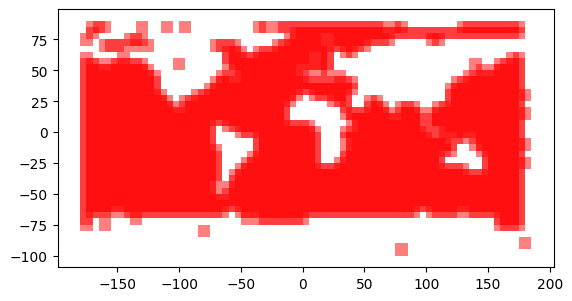

In [6]:
plot_spatial_extent(parquet_ds)

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [7]:
get_temporal_extent(parquet_ds)

(datetime.datetime(1997, 1, 1, 11, 0), datetime.datetime(2026, 1, 1, 11, 0))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [8]:
# parquet_meta = pa.parquet.read_schema(os.path.join(dname + '_common_metadata'))  # parquet metadata
get_schema_metadata(dname)  # schema metadata

{'LATITUDE': {},
 'LONGITUDE': {},
 'TEMP_ADJUSTED': {},
 'PSAL_ADJUSTED': {},
 'PRES_ADJUSTED': {},
 'PLATFORM_NUMBER': {},
 'PROJECT_NAME': {},
 'PI_NAME': {},
 'CYCLE_NUMBER': {},
 'DIRECTION': {},
 'DC_REFERENCE': {},
 'DATA_STATE_INDICATOR': {},
 'DATA_MODE': {},
 'PLATFORM_TYPE': {},
 'FLOAT_SERIAL_NO': {},
 'FIRMWARE_VERSION': {},
 'WMO_INST_TYPE': {},
 'JULD': {},
 'JULD_QC': {},
 'JULD_LOCATION': {},
 'POSITION_QC': {},
 'POSITIONING_SYSTEM': {},
 'PROFILE_PRES_QC': {},
 'PROFILE_TEMP_QC': {},
 'PROFILE_PSAL_QC': {},
 'VERTICAL_SAMPLING_SCHEME': {},
 'CONFIG_MISSION_NUMBER': {},
 'PRES': {},
 'PRES_QC': {},
 'PRES_ADJUSTED_QC': {},
 'PRES_ADJUSTED_ERROR': {},
 'TEMP': {},
 'TEMP_QC': {},
 'TEMP_ADJUSTED_QC': {},
 'TEMP_ADJUSTED_ERROR': {},
 'PSAL': {},
 'PSAL_QC': {},
 'PSAL_ADJUSTED_QC': {},
 'PSAL_ADJUSTED_ERROR': {},
 'filename': {},
 'dataset_metadata': {'metadata_uuid': '4402cb50-e20a-44ee-93e6-4728259250d2',
  'title': 'Argo Core'}}

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [9]:
filter_time = create_time_filter(parquet_ds, date_start='2018-12-01', date_end='2023-01-01')
filter_geo = create_bbox_filter(parquet_ds, lat_min=-34, lat_max=-28, lon_min=151, lon_max=160)


filter = filter_geo & filter_time

In [10]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791661 entries, 0 to 791660
Data columns (total 43 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   LATITUDE                  791661 non-null  float64       
 1   LONGITUDE                 791661 non-null  float64       
 2   TEMP_ADJUSTED             717536 non-null  float32       
 3   PRES_ADJUSTED             717600 non-null  float32       
 4   PROJECT_NAME              791661 non-null  object        
 5   PI_NAME                   791661 non-null  object        
 6   CYCLE_NUMBER              791661 non-null  float64       
 7   DIRECTION                 791661 non-null  object        
 8   DC_REFERENCE              791661 non-null  object        
 9   DATA_STATE_INDICATOR      791661 non-null  object        
 10  DATA_MODE                 791661 non-null  object        
 11  PLATFORM_TYPE             791661 non-null  object        
 12  FL

<Axes: title={'center': 'Temperature for each location'}, xlabel='TEMP_ADJUSTED', ylabel='PSAL_ADJUSTED'>

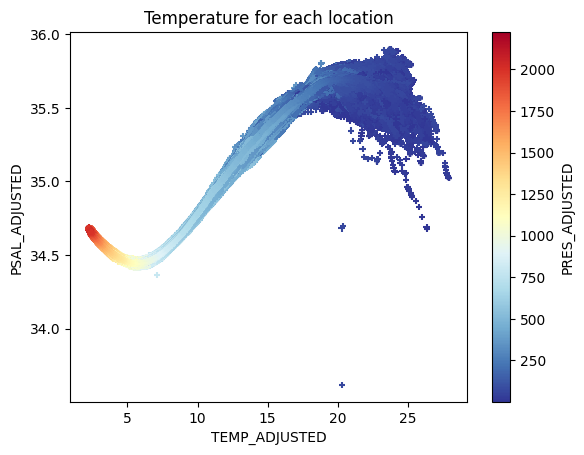

In [11]:
df.plot.scatter(x='TEMP_ADJUSTED', y='PSAL_ADJUSTED', c='PRES_ADJUSTED', marker='+', linestyle="None", cmap='RdYlBu_r', title='Temperature for each location')

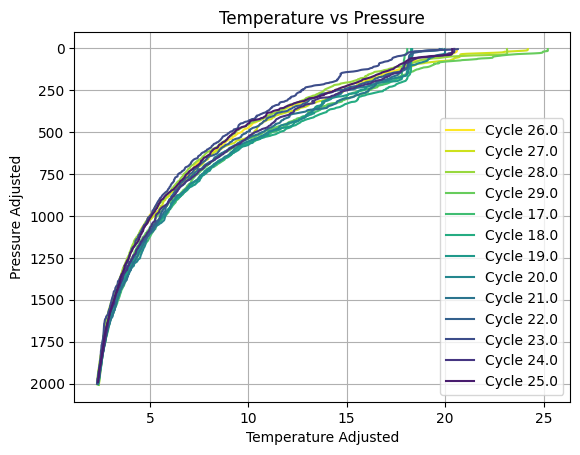

In [12]:
import matplotlib.pyplot as plt


filtered_df = df[df['PLATFORM_NUMBER'] == 5905506]

# Get unique values of CYCLE_NUMBER
unique_cycle_numbers = filtered_df['CYCLE_NUMBER'].unique()

# Define a dictionary to map each unique CYCLE_NUMBER to a color
color_mapping = {cycle_number: plt.cm.viridis_r(i / len(unique_cycle_numbers)) for i, cycle_number in enumerate(unique_cycle_numbers)}

# Plot TEMP_ADJUSTED vs PRES_ADJUSTED with different colors for each line
for cycle_number, color in color_mapping.items():
    cycle_df = filtered_df[filtered_df['CYCLE_NUMBER'] == cycle_number]
    plt.plot(cycle_df['TEMP_ADJUSTED'], cycle_df['PRES_ADJUSTED'], color=color, label=f'Cycle {cycle_number}')

plt.xlabel('Temperature Adjusted')
plt.ylabel('Pressure Adjusted')
plt.title('Temperature vs Pressure')
plt.legend()
plt.grid(True)

# Reverse the y-axis
plt.gca().invert_yaxis()

plt.show()

## Create a TIME and scalar/number filter

In [13]:
filter_time = create_time_filter(parquet_ds, date_start='2006-07-12', date_end='2023-02-05')

expr_1 = pc.field('PLATFORM_NUMBER') == 1901740
filter = expr_1 & filter_time

In [14]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150192 entries, 0 to 150191
Data columns (total 43 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   LATITUDE                  150192 non-null  float64       
 1   LONGITUDE                 150192 non-null  float64       
 2   TEMP_ADJUSTED             148320 non-null  float32       
 3   PRES_ADJUSTED             148328 non-null  float32       
 4   PROJECT_NAME              150192 non-null  object        
 5   PI_NAME                   150192 non-null  object        
 6   CYCLE_NUMBER              150192 non-null  float64       
 7   DIRECTION                 150192 non-null  object        
 8   DC_REFERENCE              150192 non-null  object        
 9   DATA_STATE_INDICATOR      150192 non-null  object        
 10  DATA_MODE                 150192 non-null  object        
 11  PLATFORM_TYPE             150192 non-null  object        
 12  FL

<Axes: title={'center': 'Temperature for each location'}, xlabel='TEMP_ADJUSTED', ylabel='PSAL_ADJUSTED'>

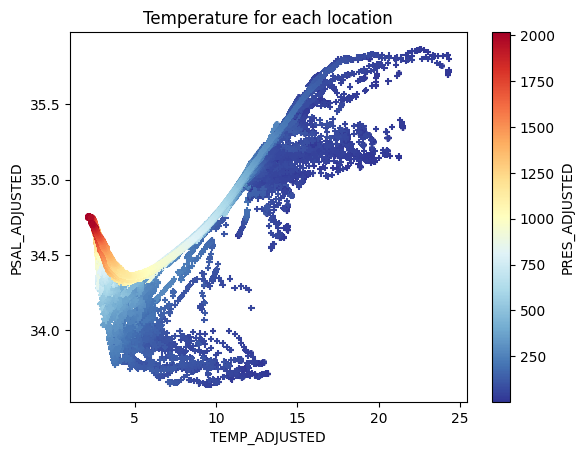

In [15]:
df.plot.scatter(x='TEMP_ADJUSTED', y='PSAL_ADJUSTED', c='PRES_ADJUSTED', marker='+', linestyle="None", cmap='RdYlBu_r', title='Temperature for each location')